In [29]:
import numpy as np
import pandas as pd

df = pd.read_csv("mtbs_tropical_annotations.tsv", sep="\t")
print(df.columns)
df.info

Index(['feature_id', 'component_id', 'libname', 'structure_inchikey',
       'structure_smiles', 'structure_molecular_formula',
       'structure_taxonomy_npclassifier_01pathway',
       'structure_taxonomy_npclassifier_02superclass',
       'structure_taxonomy_npclassifier_03class'],
      dtype='object')


<bound method DataFrame.info of        feature_id  component_id    libname           structure_inchikey  \
0           64000          2173  MS1_match  SRBFZHDQGSBBOR-HWQSCIPKSA-N   
1           64000          2173  MS1_match  PYMYPHUHKUWMLA-WDCZJNDASA-N   
2           63994          2138  MS1_match  GLDOVTGHNKAZLK-UHFFFAOYSA-N   
3           63993            47       ISDB  FZFFGBOPCQADGY-UHFFFAOYSA-N   
4           63991           664  MS1_match  KFXIUXCXSKTCNK-KLGAAMDDSA-N   
...           ...           ...        ...                          ...   
44977           6           152  MS1_match  HSPZTYQXYAPLOD-FICKGQQISA-N   
44978           6           152  MS1_match  JMOFRLILFOJJEZ-UHFFFAOYSA-N   
44979           6           152  MS1_match  IQFCUFCOJGKNJF-UHFFFAOYSA-N   
44980           6           152  MS1_match  DVILVCNQCLDLLF-HDSZUGLSSA-N   
44981           5          2285  MS1_match  IPCSVZSSVZVIGE-UHFFFAOYSA-N   

                                        structure_smiles  \
0      

In [30]:
df_clean = df.dropna(subset=['structure_smiles'])
df_clean = df_clean[df_clean['structure_smiles'] != 'nan']
df_clean = df_clean.drop_duplicates(subset=['structure_smiles'])

In [38]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, QED

descr_list = ['MolWt', 'MolLogP']
df_calc = pd.DataFrame()

def calc_descriptors(smiles, descr):
    mol = Chem.MolFromSmiles(smiles)
    return getattr(Descriptors, descr)(mol)

for descr in descr_list:
    df_calc[descr] = df_clean['structure_smiles'].apply(lambda s: calc_descriptors(s, descr))
df_calc['CalcFractionCSP3'] = df_clean['structure_smiles'].apply(lambda s: rdMolDescriptors.CalcFractionCSP3(Chem.MolFromSmiles(s)))
df_calc['qed'] = df_clean['structure_smiles'].apply(lambda s: QED.qed(Chem.MolFromSmiles(s)))
df_analysis = pd.concat([df_clean, df_calc], axis=1)
df_analysis.head()


,feature_id,component_id,libname,structure_inchikey,structure_smiles,structure_molecular_formula,structure_taxonomy_npclassifier_01pathway,structure_taxonomy_npclassifier_02superclass,structure_taxonomy_npclassifier_03class,MolWt,MolLogP,CalcFractionCSP3,qed
0,64000,2173,MS1_match,SRBFZHDQGSBBOR-HWQSCIPKSA-N,OC1OC[C@H](O)[C@H](O)[C@H]1O,C5H10O5,Carbohydrates,Saccharides,Monosaccharides,150.130,-2.5823,1.000000,0.304250
1,64000,2173,MS1_match,PYMYPHUHKUWMLA-WDCZJNDASA-N,O=C[C@@H](O)[C@H](O)[C@H](O)CO,C5H10O5,Carbohydrates,Saccharides,Monosaccharides,150.130,-2.7397,0.800000,0.325838
2,63994,2138,MS1_match,GLDOVTGHNKAZLK-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCCCO,C18H38O,Fatty acids,Fatty acyls,Fatty alcohols,270.501,6.2402,1.000000,0.329061
3,63993,47,ISDB,FZFFGBOPCQADGY-UHFFFAOYSA-N,CC(C)=CCCC(C)=CCC1(CC=C(C)C)C(=O)C(O)=Cc2oc3cc...,C28H32O6,Shikimates and Phenylpropanoids,Xanthones,Plant xanthones,464.558,6.3627,0.357143,0.411398
4,63991,664,MS1_match,KFXIUXCXSKTCNK-KLGAAMDDSA-N,C=C1C2=Nc3ccccc3[C@@]23CCN2C/C(=C/C)[C@H]1C[C@...,C19H20N2,Terpenoids,Diterpenoids,Valparane diterpenoids,276.383,3.6208,0.421053,0.660796


In [39]:
# only need to focus on top 5, otherwise there will be too many colors and less meaningful information
top5 = df_analysis['structure_taxonomy_npclassifier_01pathway'].value_counts().nlargest(5).index
df_analysis['category'] = df_analysis['structure_taxonomy_npclassifier_01pathway'].apply(lambda s: s if s in top5 else 'Other')
df_analysis.head()

,feature_id,component_id,libname,structure_inchikey,structure_smiles,structure_molecular_formula,structure_taxonomy_npclassifier_01pathway,structure_taxonomy_npclassifier_02superclass,structure_taxonomy_npclassifier_03class,MolWt,MolLogP,CalcFractionCSP3,qed,category
0,64000,2173,MS1_match,SRBFZHDQGSBBOR-HWQSCIPKSA-N,OC1OC[C@H](O)[C@H](O)[C@H]1O,C5H10O5,Carbohydrates,Saccharides,Monosaccharides,150.130,-2.5823,1.000000,0.304250,Other
1,64000,2173,MS1_match,PYMYPHUHKUWMLA-WDCZJNDASA-N,O=C[C@@H](O)[C@H](O)[C@H](O)CO,C5H10O5,Carbohydrates,Saccharides,Monosaccharides,150.130,-2.7397,0.800000,0.325838,Other
2,63994,2138,MS1_match,GLDOVTGHNKAZLK-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCCCO,C18H38O,Fatty acids,Fatty acyls,Fatty alcohols,270.501,6.2402,1.000000,0.329061,Fatty acids
3,63993,47,ISDB,FZFFGBOPCQADGY-UHFFFAOYSA-N,CC(C)=CCCC(C)=CCC1(CC=C(C)C)C(=O)C(O)=Cc2oc3cc...,C28H32O6,Shikimates and Phenylpropanoids,Xanthones,Plant xanthones,464.558,6.3627,0.357143,0.411398,Shikimates and Phenylpropanoids
4,63991,664,MS1_match,KFXIUXCXSKTCNK-KLGAAMDDSA-N,C=C1C2=Nc3ccccc3[C@@]23CCN2C/C(=C/C)[C@H]1C[C@...,C19H20N2,Terpenoids,Diterpenoids,Valparane diterpenoids,276.383,3.6208,0.421053,0.660796,Terpenoids


C:\Users\Haofu Cui\AppData\Local\Temp\ipykernel_21668\3390706384.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


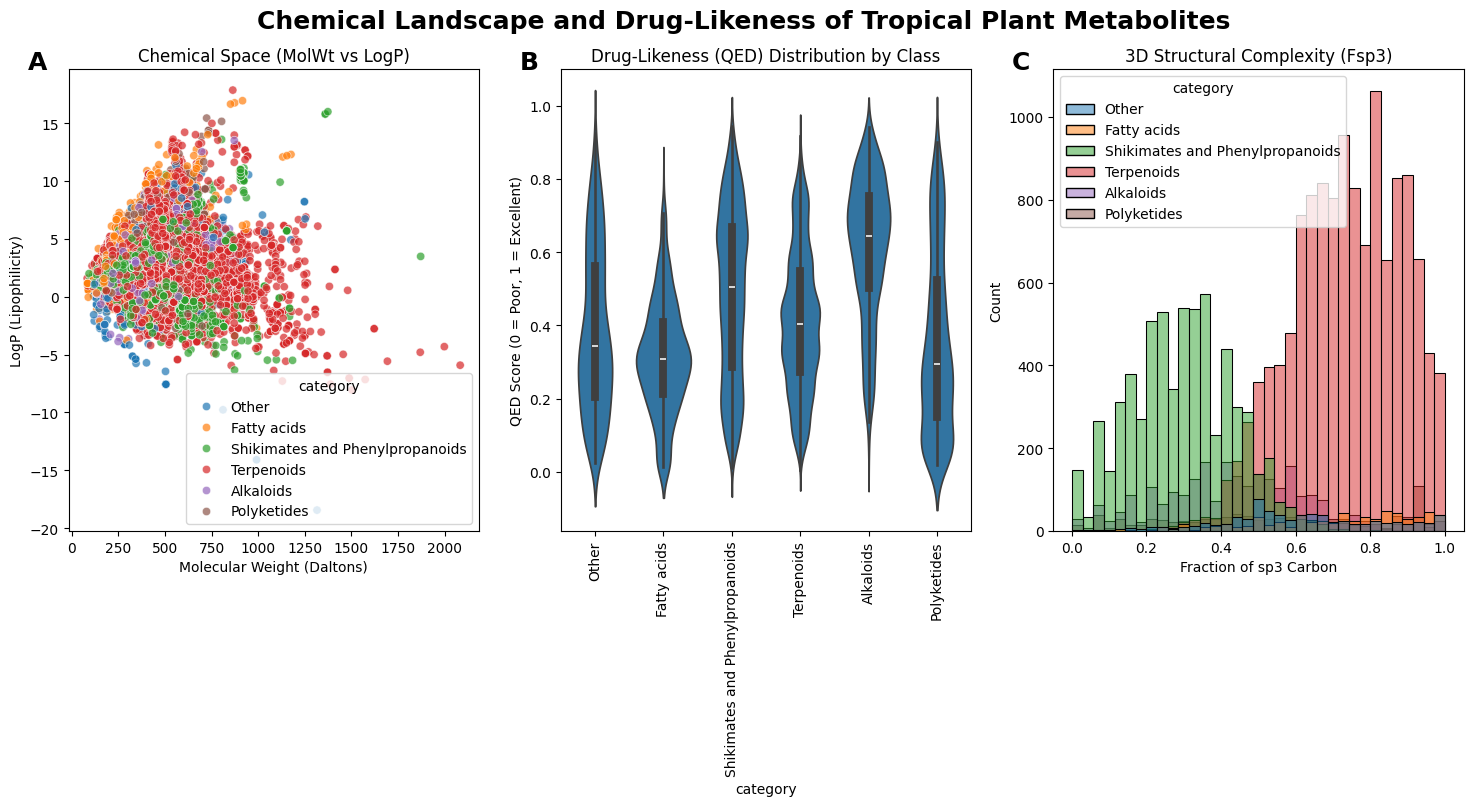

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(18, 6))
gs = GridSpec(1, 3, figure=fig)
fig.suptitle('Chemical Landscape and Drug-Likeness of Tropical Plant Metabolites', fontsize=18, weight='bold')

ax1 = fig.add_subplot(gs[0, 0])
sns.scatterplot(data=df_analysis, x='MolWt', y='MolLogP', hue='category', alpha=0.7, ax=ax1)
ax1.set_title('Chemical Space (MolWt vs LogP)')
ax1.set_xlabel('Molecular Weight (Daltons)')
ax1.set_ylabel('LogP (Lipophilicity)')
ax1.text(-0.1, 1.0, 'A', transform=ax1.transAxes, fontsize=18, fontweight='bold')
#plt.show()
ax2 = fig.add_subplot(gs[0, 1])
sns.violinplot(data=df_analysis, x='category', y='qed', ax=ax2)
ax2.set_title('Drug-Likeness (QED) Distribution by Class')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_ylabel('QED Score (0 = Poor, 1 = Excellent)')
ax2.text(1.1, 1.0, 'B', transform=ax1.transAxes, fontsize=18, fontweight='bold')
#plt.show()
ax3 = fig.add_subplot(gs[0,2])
sns.histplot(data=df_analysis, x='CalcFractionCSP3', hue='category', ax=ax3)
ax3.set_title('3D Structural Complexity (Fsp3)')
ax3.set_xlabel('Fraction of sp3 Carbon')
ax3.text(2.3, 1.0, 'C', transform=ax1.transAxes, fontsize=18, fontweight='bold')
plt.show()